# Imports

In [1]:
import json
import io
from array import array
from time import time
from PIL import Image
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import webdataset as wds
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image, ImageReadMode, decode_image
from torchvision.transforms import Compose, RandomResizedCrop, Normalize, Pad, Resize, CenterCrop
from torchvision.transforms.functional import pil_to_tensor

# 0. Prerequisites

For this research I used [this dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) of size ~780 MB, each image have different size, so to get result batch we will have to apply some transforms.

I know that ideally I should have excluded the time for preprocessing, but I decided to neglect it because of the following reasons:

1. As preprocessing happens usually inside the dataset, it will be hard to reach it;
2. Usually we always have transforms;
3. Transforms part is about 1/3 of overall time, so we will see difference if there is any.
   

In [33]:
def read_bytes(path):
    with open(path, "rb") as file:
        return file.read()

def print_results(lst_delay):
    print(f"Mean time = {np.mean(lst_delay):.4f} +/- {np.std(lst_delay):.4f}")


def measure_scores(dataset: Dataset, output_path: str, loader = None):
    if loader is None:
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    lst_delay = list()

    t_0 = time()
    for batch in tqdm(loader):
        lst_delay.append(time() - t_0)
        t_0 = time()

    with open(output_path, "w") as file:
        json.dump(lst_delay, file)

    print_results(lst_delay)

In [3]:
BATCH_SIZE = 64
NUM_WORKERS = 4

CROPS_SIZE = (224, 224)

assert torch.cuda.is_available()

In [4]:
image_root = Path("/mnt/data/images/")

# Create annotations
lst_image_path = []

for path in image_root.glob("*"):
    if not path.is_dir():
        continue

    lst_image_path.extend(path.glob("*.jpg"))
    
print(f"Total size of dataset: {len(lst_image_path)}")

Total size of dataset: 20580


In [5]:
transforms = Compose([
    CenterCrop((112, 112)),
    Resize((224, 224)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 1. Plain file

Store dataset as usual, in plain files in disk. We will use this result to compare with later.

In [6]:
class PlainFileDataset(Dataset):
    def __init__(self, lst_path):
        self.lst_path = lst_path
        
    def __len__(self):
        return len(self.lst_path)
    
    def __getitem__(self, index):
        raw_image = read_image(str(self.lst_path[index]), ImageReadMode.RGB) / 255
        processed_image = transforms(raw_image)
        
        return processed_image.float()

In [7]:
plain_file_dataset = PlainFileDataset(lst_image_path)

measure_scores(plain_file_dataset, "plain_file.json") # large std dout to several workers

  0%|          | 0/322 [00:00<?, ?it/s]

Mean time = 0.0751 +/- 0.0930


# 2. HDF5

## Description

HDF5 format stores dataset as a single file. This file can be opened and then used as key-value storage for your data. The main idea of hdf5 format can be formulated as follows:

> Groups work like dictionaries, and datasets work like NumPy arrays.

In hdf5 notation, each sample is a dataset, and those dataset is a values of the whole key-value storage. Those values can be grouped into groups, each one behaves like separate hdf5 dataset. As a consequence, you can maintain file-like structure with no additional efforts, but at the same time do not worry about how to store your files on disk, as it will be convenient numpy format.

## Pros/cons

Pros:
- Data is stored in numpy-friendly format, and supports [some of its functional](https://docs.h5py.org/en/stable/high/dataset.html#reading-writing-data).
- You can group data as you like, e.g. store all 10M images side-by-side and do not worry about a lot of files on your disk.

Cons:
- If you store images as numpy arrays, dataset size will grow dramatically (see blog-post in the Userful links section).


## Userful links

1. [Python API](https://docs.h5py.org/en/stable/)
2. [Blog about how to store large image datasets effectively using HDF5](https://blade6570.github.io/soumyatripathy/hdf5_blog.html)

## Prepare data

In [8]:
with h5py.File("dataset.hdf5", mode="w") as storage:
    for image_path in tqdm(lst_image_path):
        array_bytes = np.asarray(read_bytes(image_path))
        storage.create_dataset(str(image_path), data=array_bytes) # we can keep original folder structure with no additional efforts

  0%|          | 0/20580 [00:00<?, ?it/s]

In [10]:
class HDF5Dataset(Dataset):
    def __init__(self, dataset, lst_image_path):
        self.dataset = dataset
        self.lst_image_path = lst_image_path # just mapping
        
    def __len__(self):
        return len(self.lst_image_path)
    
    def __getitem__(self, index):
        image_path = str(self.lst_image_path[index])
        image_bytes = np.array(self.dataset[image_path]).tobytes()
        tensor_bytes = torch.frombuffer(array("B", image_bytes), dtype=torch.uint8)

        raw_tensor = decode_image(tensor_bytes, mode=ImageReadMode.RGB) / 255
        
        processed_tensor = transforms(raw_tensor)
        
        return processed_tensor

In [11]:
with h5py.File("dataset.hdf5", "r") as storage:
    dataset = HDF5Dataset(storage, lst_image_path)

    measure_scores(dataset, "hdf5_vanilla.json")

  0%|          | 0/322 [00:00<?, ?it/s]

Mean time = 0.0822 +/- 0.1140


As was supposed in the guide, let us open the dataset in the getitem method to reach better performance.

In [12]:
class HDF5DatasetFixed(Dataset):
    def __init__(self,lst_image_path, dataset_path: str):
        self.lst_image_path = lst_image_path # just mapping
        self.dataset_path = dataset_path

        self.dataset = None
        
    def __len__(self):
        return len(self.lst_image_path)
    
    def __getitem__(self, index):
        if self.dataset is None:
            self.dataset = h5py.File(self.dataset_path, "r")
    
        image_path = str(self.lst_image_path[index])
        image_bytes = np.array(self.dataset[image_path]).tobytes()
        tensor_bytes = torch.frombuffer(array("B", image_bytes), dtype=torch.uint8)

        raw_tensor = decode_image(tensor_bytes, mode=ImageReadMode.RGB) / 255
        
        processed_tensor = transforms(raw_tensor)
        
        return processed_tensor

In [13]:
with h5py.File("dataset.hdf5", "r") as storage:
    dataset = HDF5DatasetFixed(lst_image_path, "dataset.hdf5")

    measure_scores(dataset, "hdf5_fast.json")

  0%|          | 0/322 [00:00<?, ?it/s]

Mean time = 0.0815 +/- 0.1109


# LMDB

## Description
LMDB stands for [Lightning Memory-Mapped Database](https://www.symas.com/lmdb). This is not well-known format. However, it is still quite memory- and time-efficient, and allows you to store arbitrary data.

## Pros/cons

Pros

- As LMDB is a database, you automatically gets things like transactions, so your dataset can be read and write by multiple users at the same time.

Cons:

- There are not a lot of guides for this tool, so you will have to discover the original documentation.

## Userful links 

1. [Python documentation](https://lmdb.readthedocs.io/en/release/#resource-management)
2. [Example usage](https://www.cnblogs.com/sddai/p/10481869.html)


## Prepare data

In [14]:
import lmdb

In [15]:
env = lmdb.open('mylmdb', map_size=10_000_000_000)

with env.begin(write=True) as txn:
    # txn is a Transaction object
    for image_id, image_path in tqdm(enumerate(lst_image_path)):
        image_bytes = read_bytes(image_path)

        str_id = '{:08}'.format(image_id)
 
        # The encode is only essential in Python 3
        txn.put(str_id.encode('ascii'), image_bytes)

0it [00:00, ?it/s]

In [16]:
!du -sh mylmdb/

783M	mylmdb/


## Load data

In [21]:
class LMDBDataset(Dataset):
    def __init__(self, path_to_env: str, total_images: int):
        self.total_images = total_images

        self.path_to_env = path_to_env
        self.env = lmdb.open(self.path_to_env, readonly=True)
        self.txn = self.env.begin()

    def __len__(self) -> int:
        return self.total_images

    def __getitem__(self, index: int) -> torch.Tensor:        
        image_bytes = self.txn.get('{:08}'.format(index).encode("ascii"))

        tensor_bytes = torch.frombuffer(array("B", image_bytes), dtype=torch.uint8)
        raw_tensor = decode_image(tensor_bytes, mode=ImageReadMode.RGB) / 255

        processed_tensor = transforms(raw_tensor)

        return processed_tensor

In [22]:
dataset = LMDBDataset("mylmdb", len(lst_image_path))

assert torch.allclose(plain_file_dataset[0], dataset[0])

measure_scores(dataset, "lmdb.json")

  0%|          | 0/322 [00:00<?, ?it/s]

Mean time = 0.0746 +/- 0.0945


# Web Data Set

## Description

WebDataset has a lot of features, but the main is that it can access data stored on different machines. Consider the following setup:

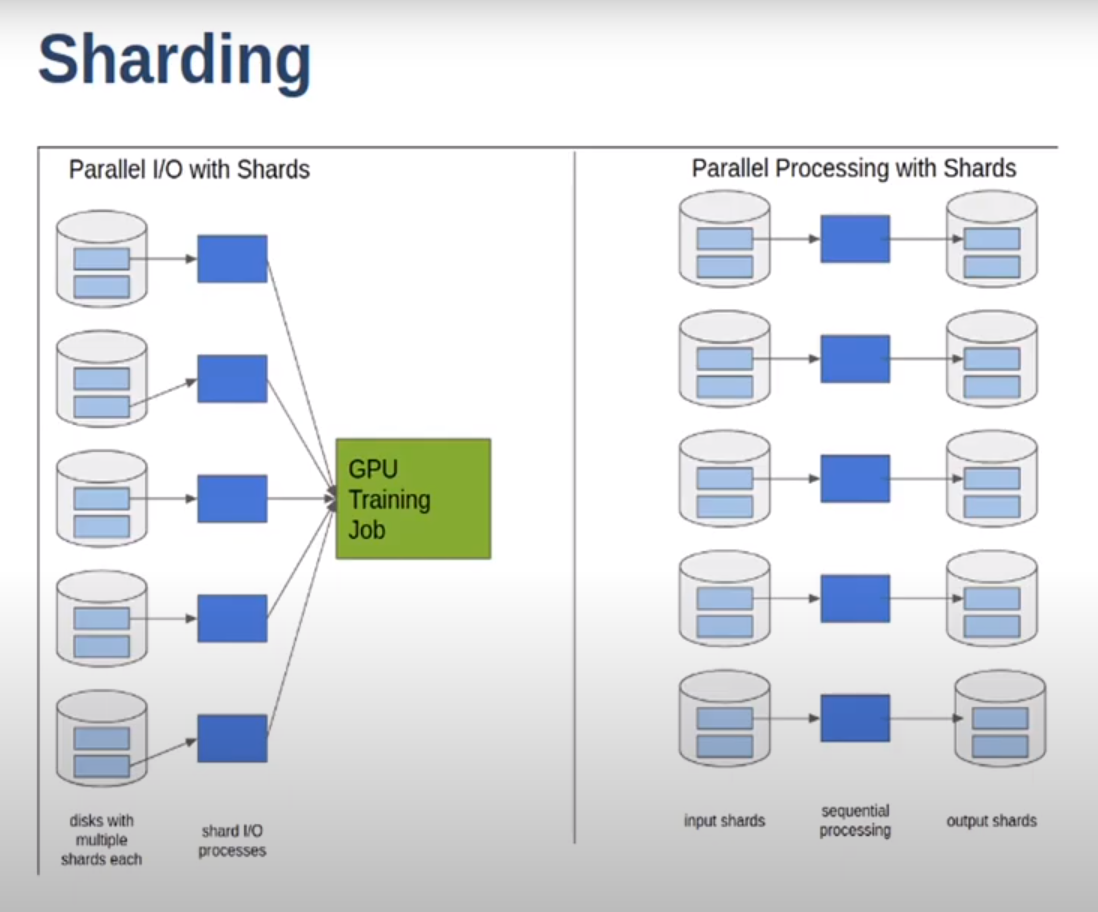

(Its taken from [this video](https://www.youtube.com/watch?v=kNuA2wflygM))

Whole data is spit by shards, and each shard is stored on the of the machines. That is when WebDataSet may come in handy: it can access data both using URLs and local filesytem. Under the hood, it stores its data as tar archives, which is common for Linux-like sytems.

Do not think that WebDataSet is dedicated only to distributed learning. Consider pros/cons section.

## Pros/cons

Pros
- Sharding, i.e. splitting the whole dataset onto smaller parts, and reading from them as a whole;
- Each WebDataset object is pytorch IterableDataset as well, which makes it easy to work with;
- Supports [preprocessing pipelines](https://webdataset.github.io/webdataset/howitworks/), which is userful for converting bytes to tensors, augmentation, etc.

Cons:
- Some features are hard to find in the original docs, and you will have to look at the source code.

## Userful links

1. [Python documentation](https://webdataset.github.io/webdataset/)
2. [Guide on how to create WebDatasets](https://www.youtube.com/watch?v=v_PacO-3OGQ)
3. [Guide on how to load data from WebDataset](https://www.youtube.com/watch?v=mTv_ePYeBhs)

## Prepare data

In [27]:
def iterate_dataset(lst_image_path):
    for index, path in enumerate(lst_image_path):
        image_bytes = read_bytes(path)

        
        sample = {
            "__key__": f"sample{index:06d}",
            "jpg": image_bytes
        }

        yield sample

In [29]:
!rm -r webdataset
!mkdir webdataset

rm: cannot remove 'webdataset': No such file or directory


In [30]:
with wds.ShardWriter("webdataset/out-%06d.tar", maxcount=1000) as sink:
    for sample in tqdm(iterate_dataset(lst_image_path)):
        sink.write(sample)

# writing webdataset/out-000000.tar 0 0.0 GB 0


0it [00:00, ?it/s]

# writing webdataset/out-000001.tar 1000 0.0 GB 1000
# writing webdataset/out-000002.tar 1000 0.0 GB 2000
# writing webdataset/out-000003.tar 1000 0.0 GB 3000
# writing webdataset/out-000004.tar 1000 0.0 GB 4000
# writing webdataset/out-000005.tar 1000 0.0 GB 5000
# writing webdataset/out-000006.tar 1000 0.0 GB 6000
# writing webdataset/out-000007.tar 1000 0.0 GB 7000
# writing webdataset/out-000008.tar 1000 0.0 GB 8000
# writing webdataset/out-000009.tar 1000 0.0 GB 9000
# writing webdataset/out-000010.tar 1000 0.0 GB 10000
# writing webdataset/out-000011.tar 1000 0.0 GB 11000
# writing webdataset/out-000012.tar 1000 0.0 GB 12000
# writing webdataset/out-000013.tar 1000 0.0 GB 13000
# writing webdataset/out-000014.tar 1000 0.0 GB 14000
# writing webdataset/out-000015.tar 1000 0.0 GB 15000
# writing webdataset/out-000016.tar 1000 0.0 GB 16000
# writing webdataset/out-000017.tar 1000 0.0 GB 17000
# writing webdataset/out-000018.tar 1000 0.0 GB 18000
# writing webdataset/out-000019.tar 1

## Load data
Pay attention on how we avoid problems with converting bytes to torch tensor using build-in method, and then apply our augmentations.

In [34]:
dataset = wds.WebDataset("webdataset/out-{000000..000020}.tar").decode("torchrgb").map_dict(jpg=transforms)

measure_scores(dataset, "webdataset.json")

0it [00:00, ?it/s]

Mean time = 0.1055 +/- 0.1346


# Summary

Let us compare the results:

In [53]:
performance_results = [
    "plain_file.json",
    "hdf5_vanilla.json",
    "hdf5_fast.json",
    "lmdb.json",
    "webdataset.json"
]

lst_mean_time = []

for path in performance_results:
    with open(path, "r") as file:
        lst_delay = json.load(file)

    average_time = np.mean(lst_delay)
    lst_mean_time.append(average_time)

In [47]:
def find_file_size(path):
    return subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8')

In [48]:
import subprocess

disk_usage = list(map(find_file_size, [
    image_root,
    "dataset.hdf5",
    "dataset.hdf5",
    "mylmdb",
    "webdataset"]))

disk_usage

['784M', '750M', '750M', '783M', '777M']

In [54]:
pd.DataFrame({
    "Method": ["Plain File", "HDF5", "HDF5 with fix", "LMDB", "WebDataSet"],
    f"Time per batch {BATCH_SIZE}": lst_mean_time,
    "Disk usage": disk_usage})

,Method,Time per batch 64,Disk usage
0,Plain File,0.075121,784M
1,HDF5,0.082212,750M
2,HDF5 with fix,0.081490,750M
3,LMDB,0.074609,783M
4,WebDataSet,0.105487,777M


## Key takeaways:

1. For such a small dataset, all methods have similar time-efficiency, except the WebDataset, which is about 33% slower;
2. All methods have similar disk usage;
3. All methods have comparable dataset creation time.

To sum up, **there is no "fastest" and "memory-cheapest" method**, you should use each one based on your other needs.